<a href="https://colab.research.google.com/github/zhong338/MFM-FM5222/blob/main/vixexample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance



     |████████████████████████████████| 63 kB 582 kB/s 
     |████████████████████████████████| 6.4 MB 13.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install statsmodels==0.13.2
!pip install scipy==1.7.1
!pip install pmdarima



     |████████████████████████████████| 9.8 MB 5.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 28.5 MB 147 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 1.4 MB 5.4 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd

import yfinance as yf




plt.rcParams['figure.figsize'] = [15, 10]

# Example

We will work with VIX data.  We will look at the daily close and 

* Perform EDA
* Fit lognormal and gamma distributions, select via AIC
* Create a Box-Cox transformed version of the data
* Fit distributions to the transformed data and select via AIC
* Use bootstrapping for our estimates
* Use MCMC to examine the posterior parameter space.


Then we will treat it as a time-series and see if we can decently ARIMA fit it.



In [ ]:
# first get data

start = '2010-01-01'
end = '2020-01-01'



vixdata = yf.download('^VIX', start = start, end = end )


vixdata.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,21.680000,21.680000,20.030001,20.040001,20.040001,0
2010-01-05,20.049999,20.129999,19.340000,19.350000,19.350000,0
2010-01-06,19.590000,19.680000,18.770000,19.160000,19.160000,0
2010-01-07,19.680000,19.709999,18.700001,19.059999,19.059999,0
2010-01-08,19.270000,19.270000,18.110001,18.129999,18.129999,0


## EDA

### Summary information




In [ ]:
vixdata.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.0
mean,16.951983,17.825095,16.142353,16.858871,16.858871,0.0
std,5.628728,6.118255,5.193262,5.630784,5.630784,0.0
min,9.010000,9.310000,8.560000,9.140000,9.140000,0.0
25%,13.140000,13.710000,12.630000,13.047500,13.047500,0.0
50%,15.600000,16.330000,14.910000,15.470000,15.470000,0.0
75%,19.027500,20.000000,18.022501,18.900000,18.900000,0.0
max,47.660000,53.290001,41.509998,48.000000,48.000000,0.0


In [ ]:
vixdata.Close.skew(), ss.kurtosis(vixdata.Close, fisher=False)


(1.7601029726413824, 6.954194621240966)

### Histogram

We will include the KDE

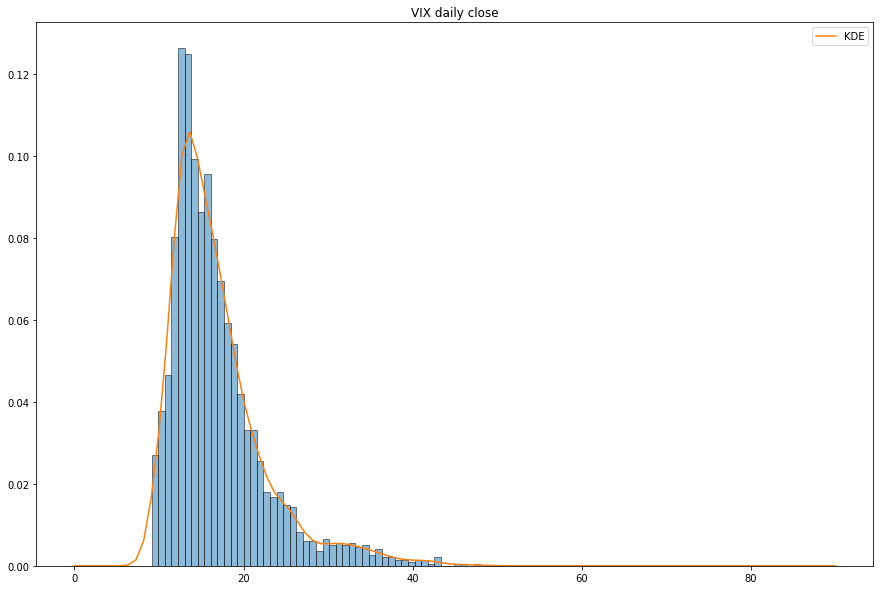

In [ ]:

v = np.linspace(0,90, 100)

plt.hist(vixdata.Close, bins = 50, alpha = .5, edgecolor="black", density = True)

plt.plot(v, ss.gaussian_kde(vixdata.Close)(v), label = "KDE")

plt.legend()

plt.title("VIX daily close")
plt.show()

We can clearly see that it is skewed right.  Note also that the minimum (at least in the data set) is not zero.


### Boxplot

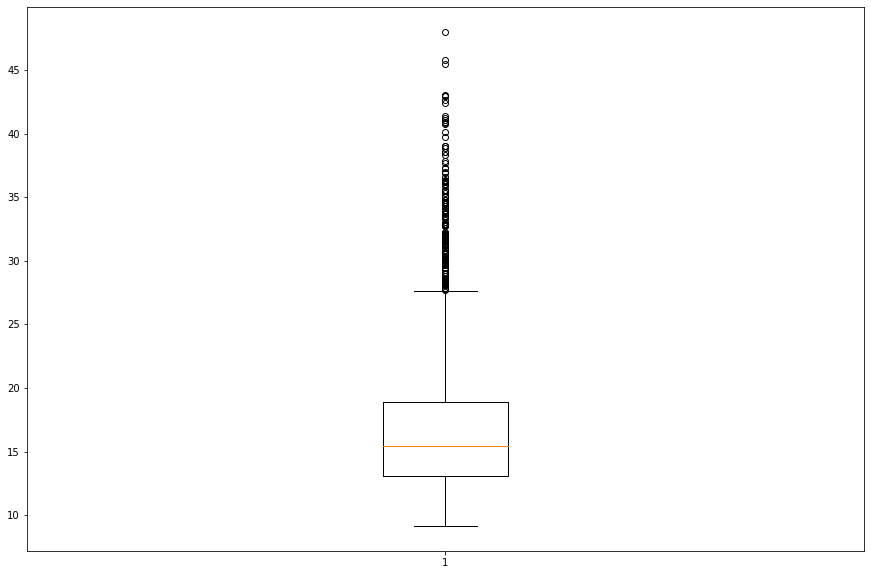

In [ ]:
plt.boxplot(vixdata.Close)
plt.show()


## Fitting Gamma and Lognormal.

Though we could spend some time with moment-matching approaches, we will mainly use MLE.   We will look at

* Lognormal with loc = 0
* Lognormal with loc a parameter
* Gamma with loc = 0
* Gamma is loc a parameter

We will calculate the log-liklihood of each of the fits.    


### Lognormal with loc =0

Recall that $Y$ is lognormally distributed with parameters $\mu$ and $\sigma$ if $X = \ln(Y)$ is normal with mean $\mu$ and variance $\sigma^2$.

In scipy stats, the shape parameter is $s = \sigma$.

The scale parameter is $\text{scale} = e^{\mu}$


The location shifts the distribution to have a minimum other than $0$.



The fit method in scipy.stats numerically does mle for us.   We can use floc = 0 to fix the location parameter.


In [ ]:
fit1 = ss.lognorm.fit(vixdata.Close, floc = 0)

fit1

(0.29103802695376696, 0.0, 16.104846611394883)

This means that $\hat{\sigma} = .29$ and that $\hat{\mu} = \ln(16.1)$


We we calculate the log-liklihood (for later use) and plot our fit to see whether we like it.

In [ ]:
llh1 = ss.lognorm.logpdf(vixdata.Close, s= fit1[0], loc = 0, scale= fit1[2]).sum()
llh1

-7456.813739486852

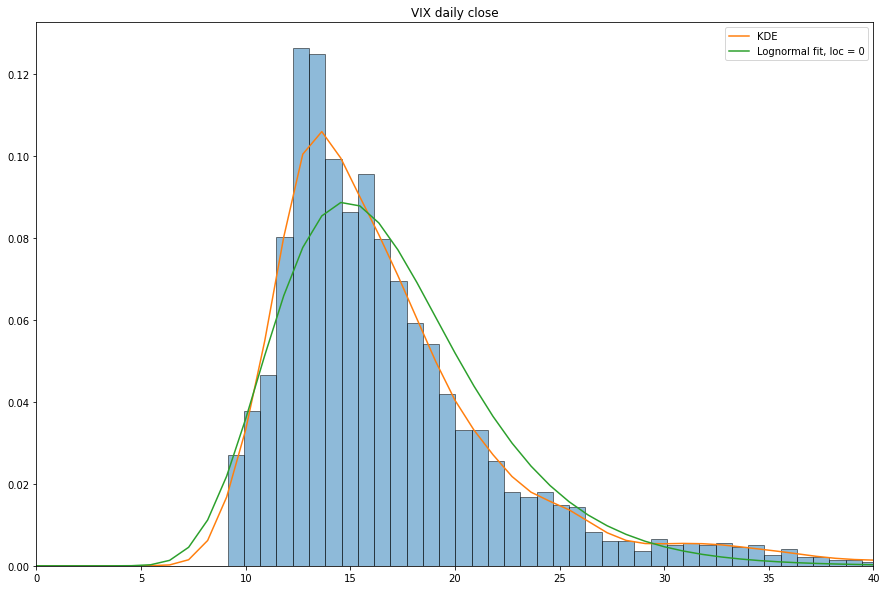

In [ ]:


plt.hist(vixdata.Close, bins = 50, alpha = .5, edgecolor="black", density = True)

plt.plot(v, ss.gaussian_kde(vixdata.Close)(v), label = "KDE")

plt.plot(v, ss.lognorm.pdf(v,s= fit1[0], loc = 0, scale= fit1[2] ), label = "Lognormal fit, loc = 0")

plt.legend()


plt.xlim(0,40)

plt.title("VIX daily close")
plt.show()

### Lognormal with loc a parameter




In [ ]:
fit2 = ss.lognorm.fit(vixdata.Close)

fit2

(0.5658774222065233, 7.680322081027853, 7.815934446209771)

In [ ]:
llh2 = ss.lognorm.logpdf(vixdata.Close, s= fit2[0], loc = fit2[1], scale= fit2[2]).sum()
llh2

-7310.801157948104

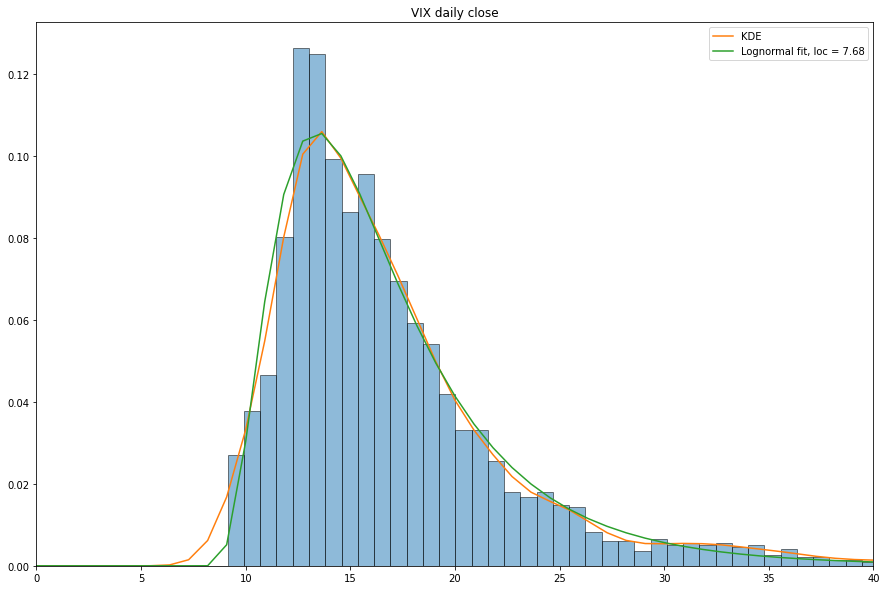

In [ ]:
plt.hist(vixdata.Close, bins = 50, alpha = .5, edgecolor="black", density = True)

plt.plot(v, ss.gaussian_kde(vixdata.Close)(v), label = "KDE")

plt.plot(v, ss.lognorm.pdf(v,s= fit2[0], loc = fit2[1], scale= fit2[2] ), label = "Lognormal fit, loc = "+str(np.round(fit2[1],2)))

plt.legend()

plt.xlim(0,40)

plt.title("VIX daily close")
plt.show()

### Gamma fit, loc = 0


Recall the Gamma distribution is given by the PDF

$$f_X(x;\alpha, \beta) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} x^{\alpha-1} e^{-\beta x}$$


In scipystats, $a = \alpha$ is a shape parameter.  The scale parameter is $\text{scale} = \frac{1}{\beta}$

In [ ]:
fit3 = ss.gamma.fit(vixdata.Close, floc = 0)

fit3

(11.091419877428043, 0, 1.5199921562258958)

In [ ]:
llh3 = ss.gamma.logpdf(vixdata.Close, a = fit3[0], loc = fit3[1], scale = fit3[2]).sum()
llh3

-7573.138347916489

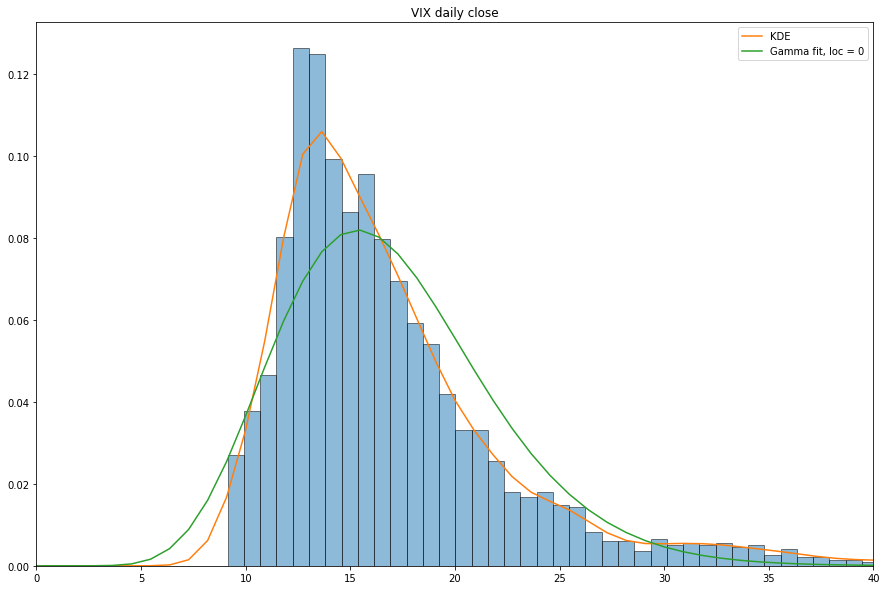

In [ ]:
plt.hist(vixdata.Close, bins = 50, alpha = .5, edgecolor="black", density = True)

plt.plot(v, ss.gaussian_kde(vixdata.Close)(v), label = "KDE")

plt.plot(v, ss.gamma.pdf(v,a= fit3[0], loc = fit3[1], scale= fit3[2] ), label = "Gamma fit, loc = "+str(np.round(fit3[1],2)))

plt.legend()
plt.xlim(0,40)
plt.title("VIX daily close")
plt.show()

### Gamma fit, loc is a parameter



In [ ]:
fit4 = ss.gamma.fit(vixdata.Close)

fit4

(2.1874853674663193, 9.028601324838156, 3.579585407076558)

In [ ]:
llh4 = ss.gamma.logpdf(vixdata.Close, a = fit4[0], loc = fit4[1], scale = fit4[2]).sum()
llh4

-7334.419642088239

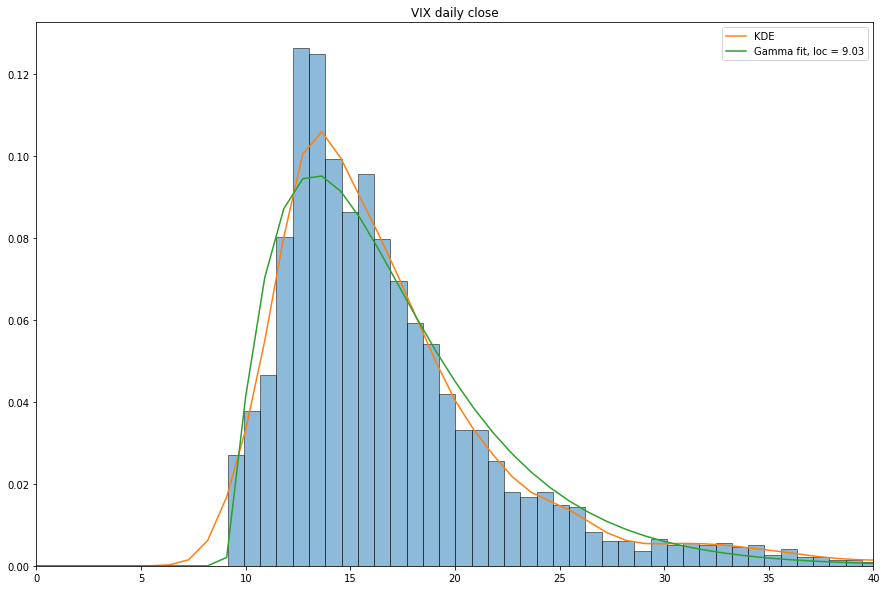

In [ ]:
plt.hist(vixdata.Close, bins = 50, alpha = .5, edgecolor="black", density = True)

plt.plot(v, ss.gaussian_kde(vixdata.Close)(v), label = "KDE")

plt.plot(v, ss.gamma.pdf(v,a= fit4[0], loc = fit4[1], scale= fit4[2] ), label = "Gamma fit, loc = "+str(np.round(fit4[1],2)))

plt.legend()

plt.xlim(0,40)

plt.title("VIX daily close")
plt.show()

### AIC selection

Recall that $AIC = -2\ell + 2p$

and smaller is better.

In [ ]:
AIC1 = -2*llh1 + 2*2
AIC2 = -2*llh2 + 2*3
AIC3 = -2*llh3 + 2*2
AIC4 = -2*llh4 + 2*3


print(AIC1, AIC2, AIC3, AIC4)


14917.627478973704 14627.602315896209 15150.276695832978 14674.839284176478


Hence, we would choose the lognormal distribution with location a parameter.

## Box-Cox

Recall that Box-Cos is one way to make an asymmetric distribution less so.  We will in this example not shift before applying it, but that is something that can always be considered.

Recall that the transform is:

$$x_i \to \begin{cases}\frac{x_i^{\alpha} -1}{\alpha},& \alpha \neq 0\\ \ln(x_i), & \alpha = 0 \\ \end{cases}$$


In sciypy stats, $\text{lmbda} = \alpha$

Since we have right-skew, we expect to settle on $\alpha$ value less than $1$.

Let's plot a few:



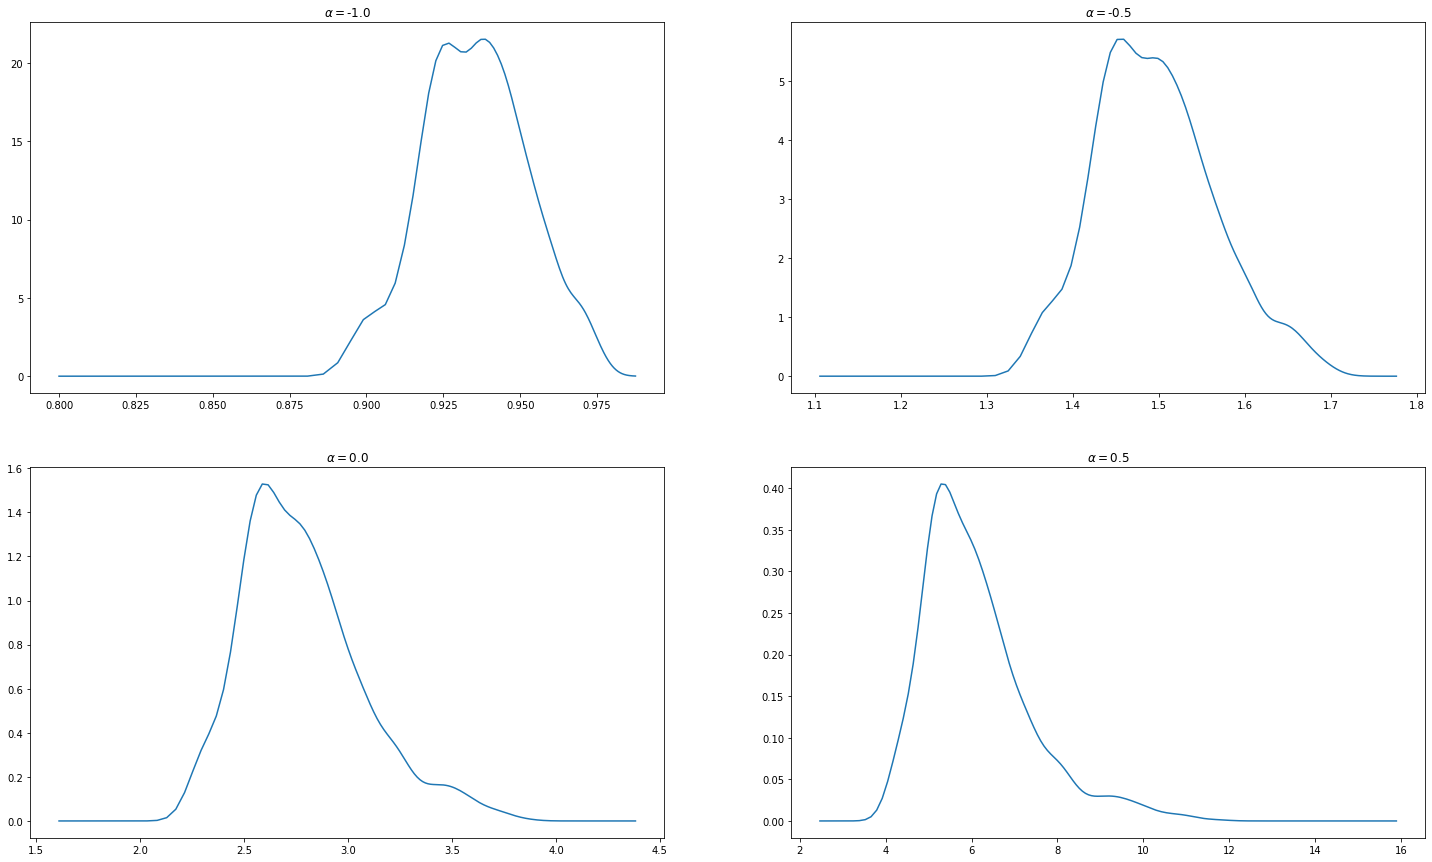

In [ ]:
v =np.linspace(5, 80, 200)

plt.figure(figsize=(25,15))
for i, lam in  enumerate(np.array([-1, -.5, 0,.5, ])):
  
  plotstring = "22"+str(i+1) 
  plt.subplot(plotstring)
  
  bc = lambda x: ss.boxcox(x,lam)

  plt.plot(bc(v), ss.gaussian_kde(bc(vixdata.Close))(bc(v)))


  plt.title("$\\alpha =$"+str(lam) )





By visual inspection, we might take $\alpha \approx -1$  

So we inspect closer:

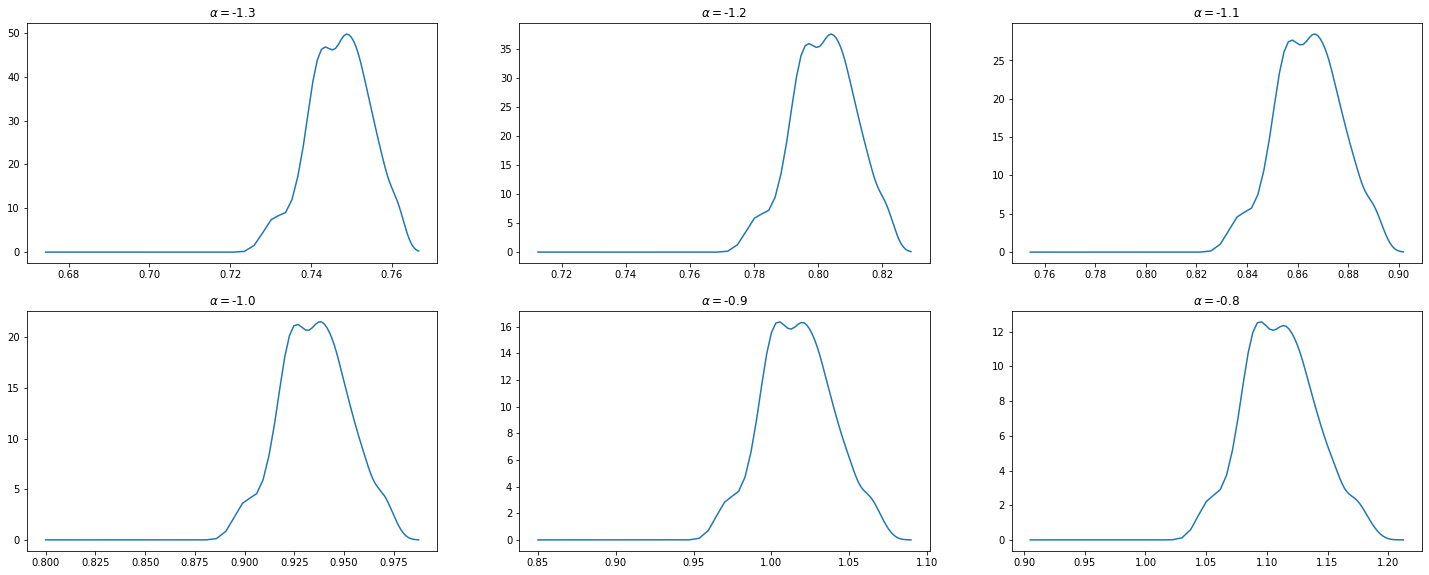

In [ ]:
plt.figure(figsize=(25,15))
for i, lam in  enumerate(np.array([-1.3, -1.2, -1.1, -1, -.9,-.8 ])):

  plotstring = "33"+str(i+1) 
  plt.subplot(plotstring)
  
  bc = lambda x: ss.boxcox(x,lam)

  plt.plot(bc(v), ss.gaussian_kde(bc(vixdata.Close))(bc(v)))


  plt.title("$\\alpha =$"+str(lam) )

In [ ]:
for i, lam in  enumerate(np.array([-1.3, -1.2, -1.1, -1, -.9,-.8 ])):
   bc = lambda x: ss.boxcox(x,lam)
   print("skew with alpha = "+str(lam), "is " , ss.skew(bc(vixdata.Close)) )






skew with alpha = -1.3 is  -0.18870302429037208
skew with alpha = -1.2 is  -0.12063286354356614
skew with alpha = -1.1 is  -0.05163840522626219
skew with alpha = -1.0 is  0.018355382756443016
skew with alpha = -0.9 is  0.08942716903969908
skew with alpha = -0.8 is  0.16165895316141388


Let's go with $\alpha = -1.1$

In [ ]:
vix_bc = ss.boxcox(vixdata.Close, -1.1)

Making a plot

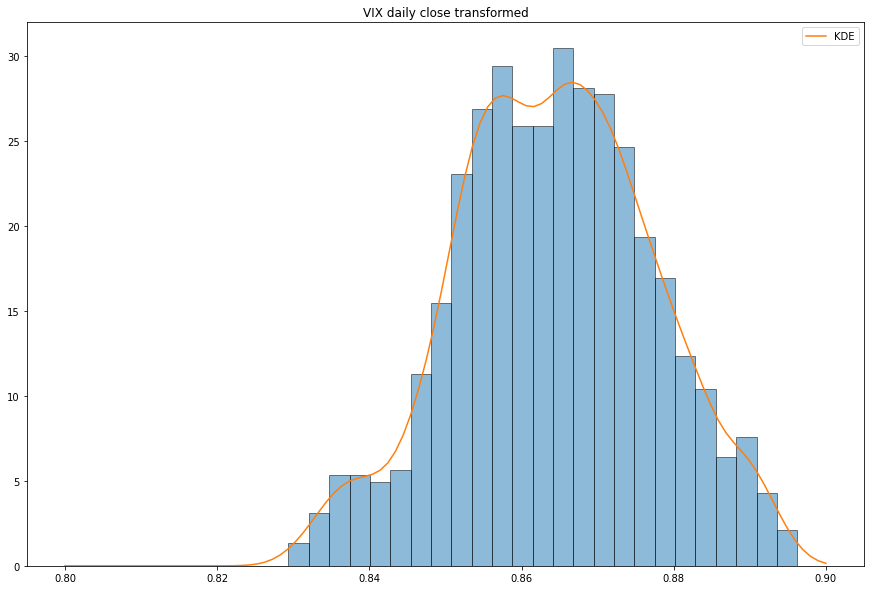

In [ ]:
vcb = np.linspace(.8,.9, 100)

plt.hist(vix_bc, bins = 25, alpha = .5, edgecolor="black", density = True)

plt.plot(vcb, ss.gaussian_kde(vix_bc)(vcb), label = "KDE")

plt.legend()

plt.title("VIX daily close transformed")
plt.show()

Let's fit normal, student T and GED (gennorm in scipy.stats)


### Normal

Recall that for the normal distribution, the MLE and moment matching is the same.

In [ ]:
fitBC1 = ss.norm.fit(vix_bc)
print(fitBC1, vix_bc.mean(), vix_bc.std()) 

(0.8642731209023361, 0.012973365499263827) 0.8642731209023361 0.012973365499263827


In [ ]:
llhBC1 = ss.norm.logpdf(vix_bc, loc = fitBC1[0], scale = fitBC1[1]).sum()

llhBC1

7361.610437120315

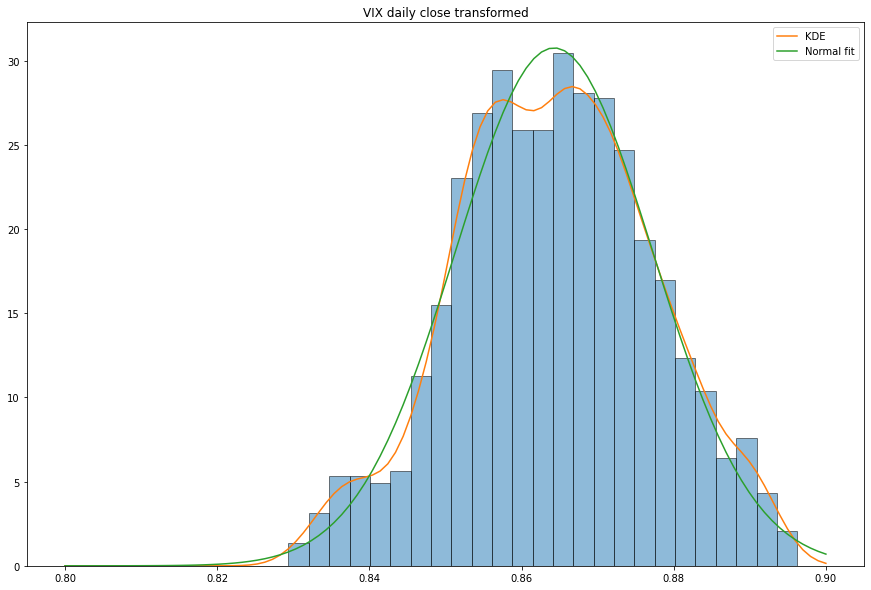

In [ ]:
plt.hist(vix_bc, bins = 25, alpha = .5, edgecolor="black", density = True)

plt.plot(vcb, ss.gaussian_kde(vix_bc)(vcb), label = "KDE")

plt.plot(vcb, ss.norm.pdf(vcb, loc =fitBC1[0], scale = fitBC1[1] ), label ="Normal fit")


plt.legend()

plt.title("VIX daily close transformed")
plt.show()

### Student T

Recall that in the Student t, if the degree fredom is much larger than 30, then it is more or less the normal distribution.

In [ ]:
fitBC2 = ss.t.fit(vix_bc)
fitBC2 

(4801089.686210862, 0.8642719488429513, 0.012973201700411163)

Note that when see that the fitted df is $480$K, we neglect studying this further and this is just the normal fit. 

### Gennorm

Recall the the PDF for the gennorm is

$$f_X(x;\beta)\propto e^{-|x|^{\beta}}  $$


$\beta=2$ is Gaussian.

$\beta=1$ the Lapace or double-exponential.



In [ ]:
fitBC3 = ss.gennorm.fit(vix_bc)
fitBC3

(2.318536135970496, 0.8642607846474377, 0.019619586020409873)

In [ ]:
llhBC3 = ss.gennorm.logpdf(vix_bc, beta = fitBC3[0], loc = fitBC3[1], scale = fitBC3[2]).sum()

llhBC3

7366.356392389682

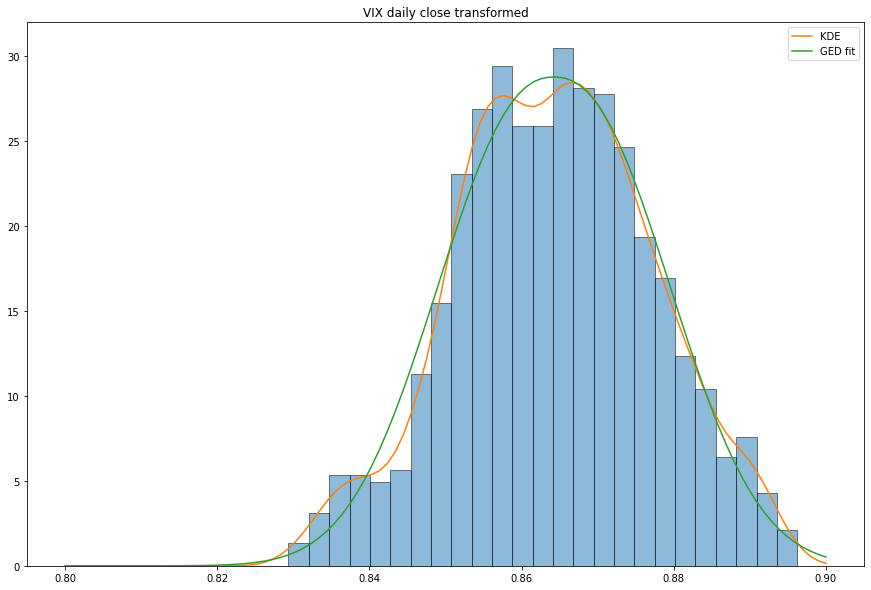

In [ ]:
plt.hist(vix_bc, bins = 25, alpha = .5, edgecolor="black", density = True)

plt.plot(vcb, ss.gaussian_kde(vix_bc)(vcb), label = "KDE")

plt.plot(vcb, ss.gennorm.pdf(vcb, beta = fitBC3[0] ,loc =fitBC3[1], scale = fitBC3[2] ), label ="GED fit")


plt.legend()

plt.title("VIX daily close transformed")
plt.show()

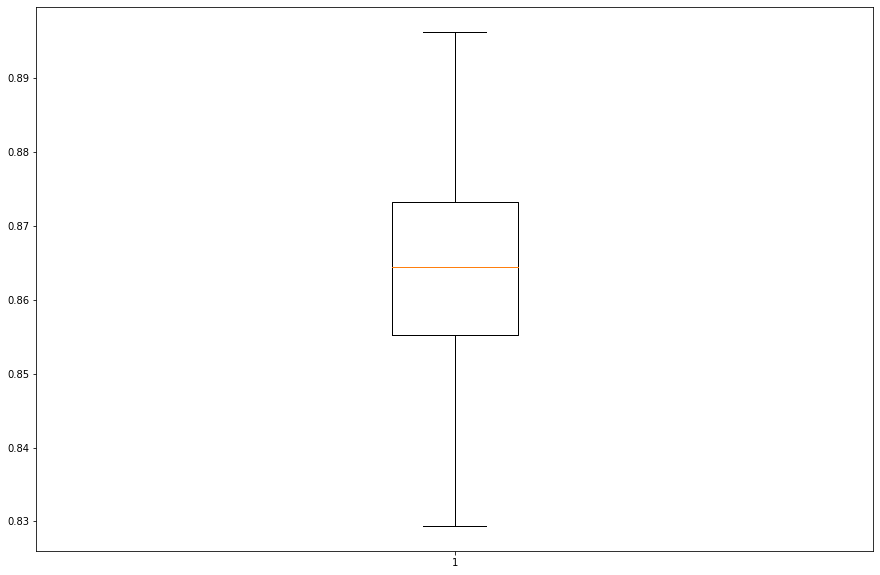

In [ ]:
plt.boxplot(vix_bc)

plt.show()

### AIC

We compare the normal and GED gits with AIC

In [ ]:
AIC_bc1 = -2*llhBC1 + 2*2

AIC_bc3 = -2*llhBC3 + 2*3

AIC_bc1, AIC_bc3


(-14719.22087424063, -14726.712784779364)

We see that the gennorm is the winner (smaller is better - more negative is smaller).

## Bootstrapping to assess our estimates.


### Untransformed data

We choose the lognormal model where the location is parameter.



In [ ]:
M = 1000


bs_ests = np.zeros([M,3])



for k in range(M):

  sample = np.random.choice(vixdata.Close, size = len(vixdata.Close), replace = True)  

  bs_ests[k,:] = ss.lognorm.fit(sample)


  



#### Bias

We compare the mean of our sampled estimates to our actual estimates

In [ ]:
fit2

(0.5658774222065233, 7.680322081027853, 7.815934446209771)

In [ ]:
bias = fit2 - bs_ests.mean(axis=0)

bias

array([-0.00183536, -0.0054892 ,  0.0112525 ])

These seem pretty small (relatively).

#### Variance of estimator

We actually the square root of the variance estimate.

A relative value can be of use as well.


In [ ]:
se =  bs_ests.std(axis=0)

print(se)

print(se/fit2)

[0.03129075 0.16365151 0.32341315]
[0.05529598 0.0213079  0.04137869]


#### Confidence Interval

Recall the basic bootstrap CI is obtained via


$$CI = \left[2\hat{\theta} - q_U  ,2\hat{\theta}  - q_L)       \right]$$


where $[q_L,q_U]$ is the CI for the bootstrapped estimates.

Let's do $94\%$ (so we can compare to MCMC later).

In [ ]:
qL = np.quantile(bs_ests, .03, axis = 0)
qU = np.quantile(bs_ests, .97, axis = 0)

print("The basic bootstrap at 94% lower boundaries are ",  2*np.array(fit2) - qU)

print("The basic bootstrap at 94% upper boundaries are ",  2*np.array(fit2) - qL)



The basic bootstrap at 94% lower boundaries are  [0.53567576 7.39627686 7.44812263]
The basic bootstrap at 94% upper boundaries are  [0.59384086 7.95653743 8.19059604]


## MCMC

We now use MCMC to examine the same lognormal fit.

Since we don't have a prior, we will "cheat" and use a prior that is relatively flat and fully encloses our basic bootstrap CI.


We will need to correspond the scipy.stats parameters with how they are understood in pymc3. Here are the correspondences.

$s = \sigma$
$\text{scale} = e^{\mu}$

or

$\ln(\text{scale}) = \mu$


$\text{loc}$ is the same, but will need to be done manually.




In [ ]:
mu_L = np.log(2*np.array(fit2) - qU)[2]
mu_U = np.log(2*np.array(fit2) - qL)[2]

print(mu_L, mu_U)

2.0079620050274953 2.1029866714080314


In [ ]:
import pymc3 as pm
import arviz as az

In [ ]:
fitmodel = pm.Model()

with fitmodel:

  # Set priors

  loc = pm.Uniform('loc', lower=6, upper = 9)

  mu = pm.Uniform('mu',lower = 1.5, upper = 2.5)

  sigma = pm.Uniform('sigma', lower = .4, upper = .7)

  # observed

  yobs = pm.Lognormal('yobs', mu = mu, sigma = sigma, observed = np.array(vixdata.Close) - loc )


                     


In [ ]:
with fitmodel:

  trace = pm.sample(1000)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu, loc]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


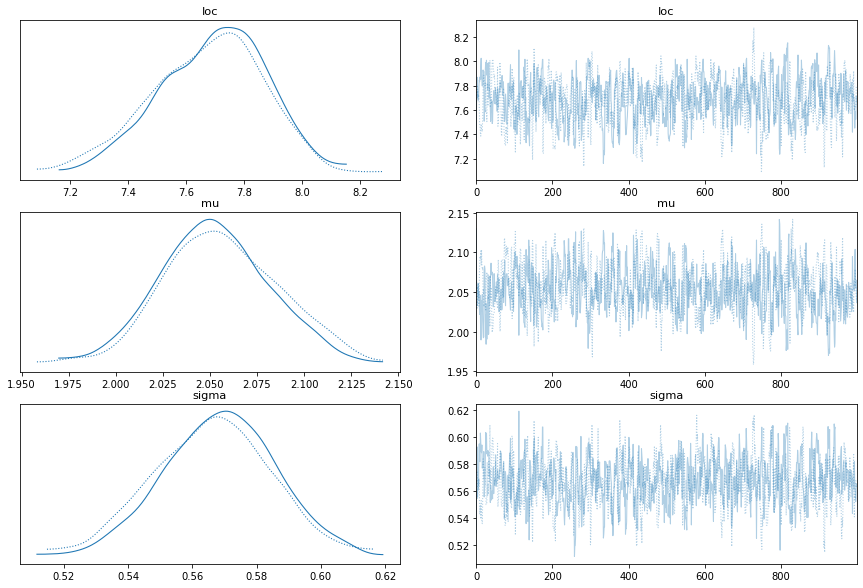

In [ ]:
with fitmodel: 
    
    az.plot_trace(trace, figsize = (15,10))

Let's look at the plots more closely

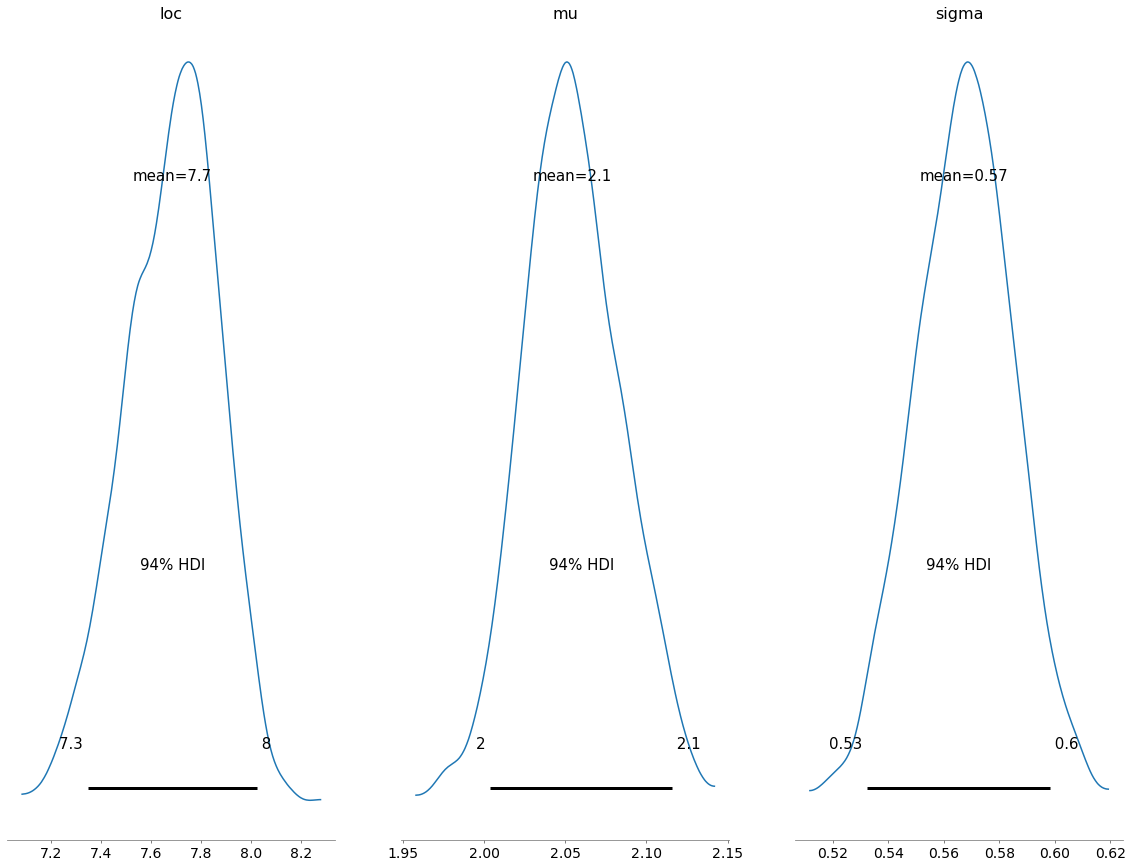

In [ ]:
with fitmodel:  
  
  az.plot_posterior(trace, figsize = (20,15))



In [ ]:
with fitmodel:
    summary = az.summary(trace)
    
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc,7.684,0.185,7.347,8.026,0.008,0.006,506.0,671.0,1.01
mu,2.055,0.030,2.004,2.116,0.001,0.001,524.0,728.0,1.01
sigma,0.567,0.018,0.532,0.598,0.001,0.001,547.0,803.0,1.01


Our basic bootstrap CIs were

$\text{loc} \in [7.41, 7.96 ]$

$ \mu \in [2.01, 2.10 ]  $

$\sigma \in [.537, .593 ]$

## Time Series


We now treat the vix close as a time series. 

What is different about that?






### Stationary?

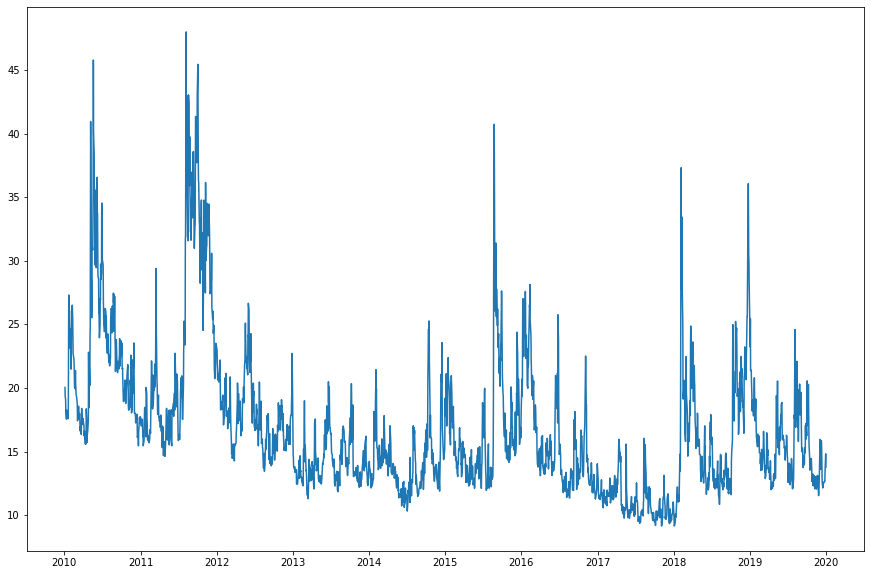

In [ ]:
plt.plot(vixdata.Close)

plt.show()

A downward trend?   We will test shortly for stationarity


It's likely not White Noise, but let's plot the auto-correlation

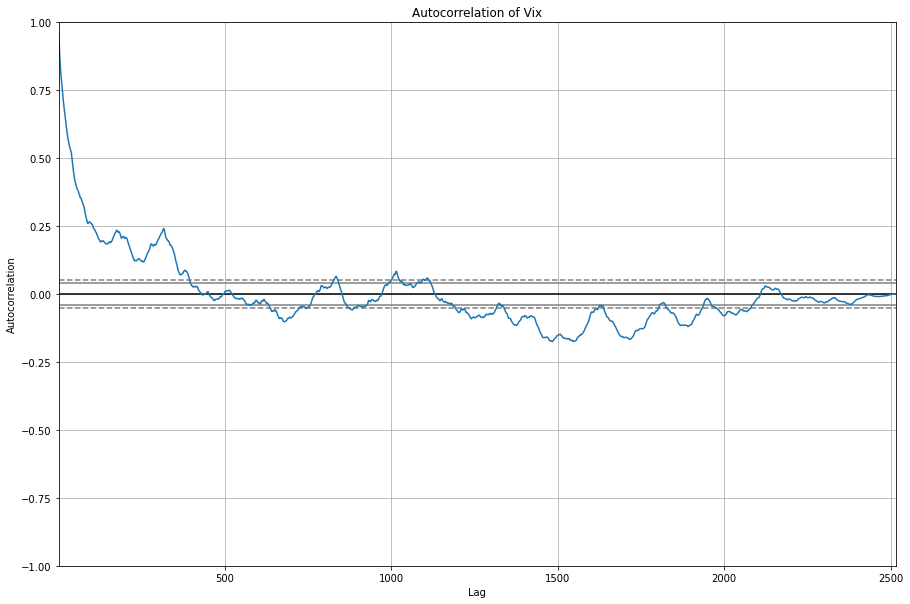

In [ ]:
plt.figure(figsize = (15,10))

x = pd.plotting.autocorrelation_plot(vixdata.Close)
 
# plotting the Curve
x.plot()

plt.title("Autocorrelation of Vix")
 
# Display
plt.show()

From the plot, clearly not White Noise.  We can verify wiht Lejung-Box

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox as lbox


lbox(vixdata.Close)

,lb_stat,lb_pvalue
1,2314.125681,0.0
2,4471.515940,0.0
3,6488.417932,0.0
4,8393.755193,0.0
5,10201.239863,0.0
6,11935.299931,0.0
7,13599.758466,0.0
8,15210.792258,0.0
9,16772.230162,0.0
10,18291.426561,0.0


### Stationary -   KPSS

We are concerned about a possibly downward trend, which would mean not stationary.  We use the KPSS test.

Recall that in this test, the null-hypothesis is that the process is stationary.

In [ ]:
from statsmodels.tsa.stattools import kpss


kpss(vixdata.Close)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


(2.349669892588851,
 0.01,
 29,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

This means that indeed there is a tend,  we should difference! 


In [ ]:
vixD = vixdata.Close.diff().dropna()

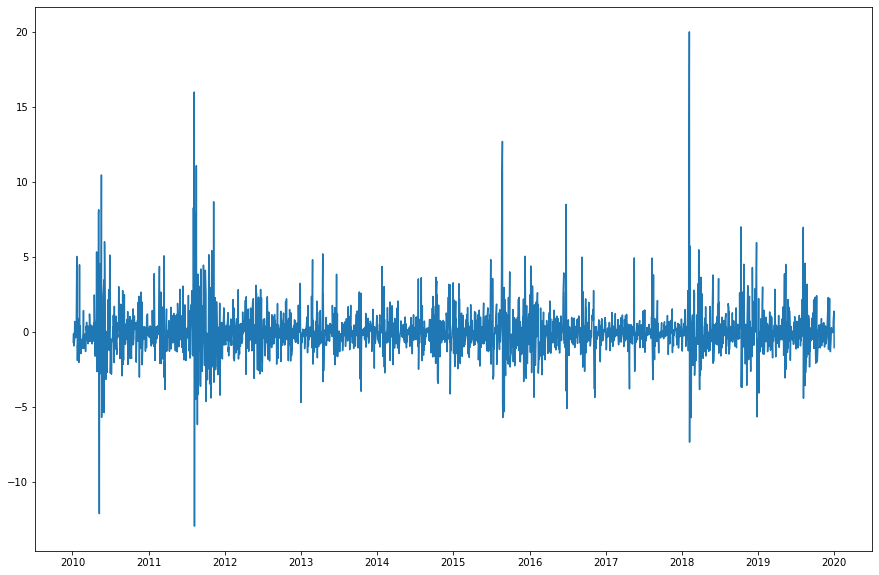

In [ ]:
plt.plot(vixD)

plt.show()

Like above, let plot the autocorrelations and test for White Noise.

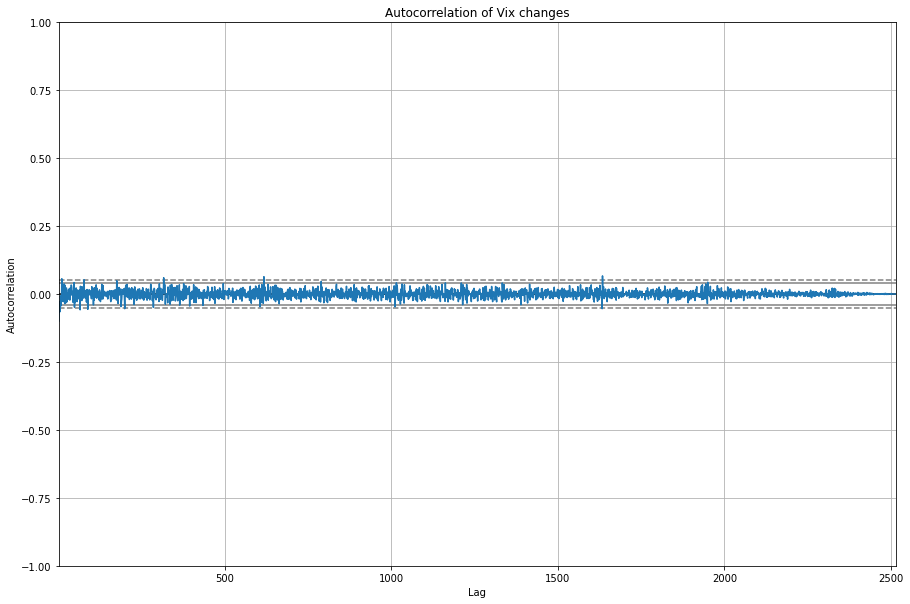

In [ ]:
plt.figure(figsize = (15,10))

x = pd.plotting.autocorrelation_plot(vixD)
 
# plotting the Curve
x.plot()

plt.title("Autocorrelation of Vix changes")
 
# Display
plt.show()

White Noise?  Let's look at the first few lags.

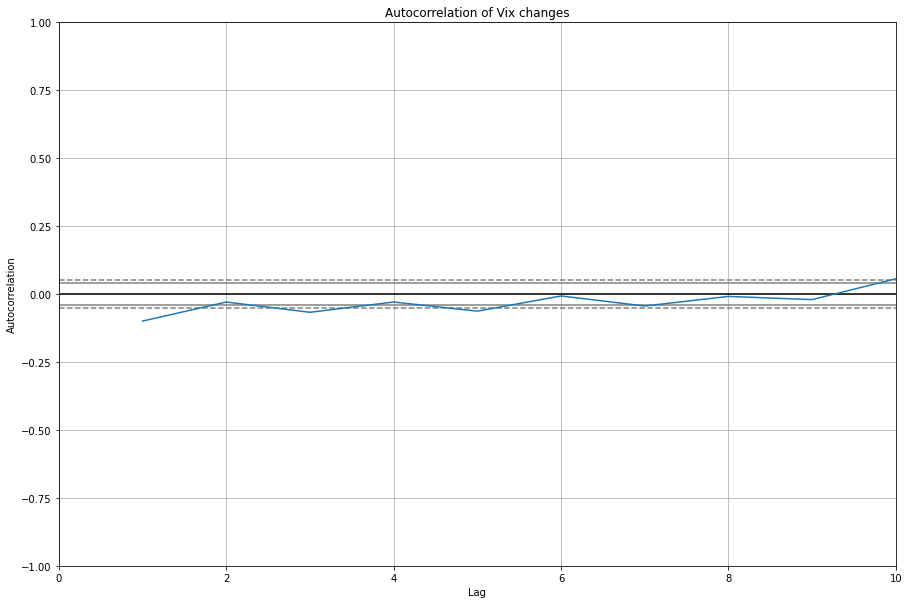

In [ ]:
plt.figure(figsize = (15,10))

x = pd.plotting.autocorrelation_plot(vixD)
 
# plotting the Curve
x.plot()

plt.title("Autocorrelation of Vix changes")
plt.xlim(0,10)
 
# Display
plt.show()

Time for Lejung-Box

In [ ]:
lbox(vixD)

,lb_stat,lb_pvalue
1,24.986325,5.773838e-07
2,27.185089,1.249778e-06
3,38.604723,2.104715e-08
4,40.799214,2.957802e-08
5,50.845672,9.301778e-10
6,50.978192,2.991914e-09
7,55.897384,9.897262e-10
8,56.098070,2.699475e-09
9,57.172419,4.683548e-09
10,65.103227,3.873106e-10


OK, so LB is rather conclusive that this is not White Noise. 


### Unit Roots?

Before we run Auto ARIMA, let's directly test for Unit Roots


#### Dickey-Fuller

Recall that the null hypothesis here is that the process does have a unit root.


In [ ]:
from statsmodels.tsa.stattools import adfuller


adfuller(vixD)

(-14.048339951161546,
 3.210672587305591e-26,
 18,
 2496,
 {'1%': -3.432972611342269,
  '10%': -2.567386797035513,
  '5%': -2.862698654944332},
 9387.878243001516)

Good.  We can safely model the once differences series as ARMA(p,q).


We will however now let auto ARIMA do the work.

In [ ]:
from pmdarima import auto_arima

In [ ]:
auto_arima(vixdata.Close, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9490.613, Time=3.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9568.987, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9545.910, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9543.553, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9566.993, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9493.507, Time=2.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9492.968, Time=4.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9492.612, Time=5.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9493.832, Time=2.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9494.550, Time=2.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9494.429, Time=2.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9494.614, Time=2.94 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=9488.651, Time=1.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

So, 2 Autroregressed terms and 2 moving average terms is the best fit (according to AIC).

Let fit it and look at the diagnostics

In [ ]:
from statsmodels.tsa.arima.model import ARIMA


vix_ts = ARIMA(vixdata.Close, order=(2, 1, 2))
result = vix_ts.fit()

print(result.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2516
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4739.326
Date:                Fri, 29 Apr 2022   AIC                           9488.651
Time:                        00:21:35   BIC                           9517.802
Sample:                             0   HQIC                          9499.231
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0372      0.060     -0.617      0.537      -0.155       0.081
ar.L2          0.7210      0.047     15.318      0.000       0.629       0.813
ma.L1         -0.0855      0.063     -1.365      0.1

And some plots

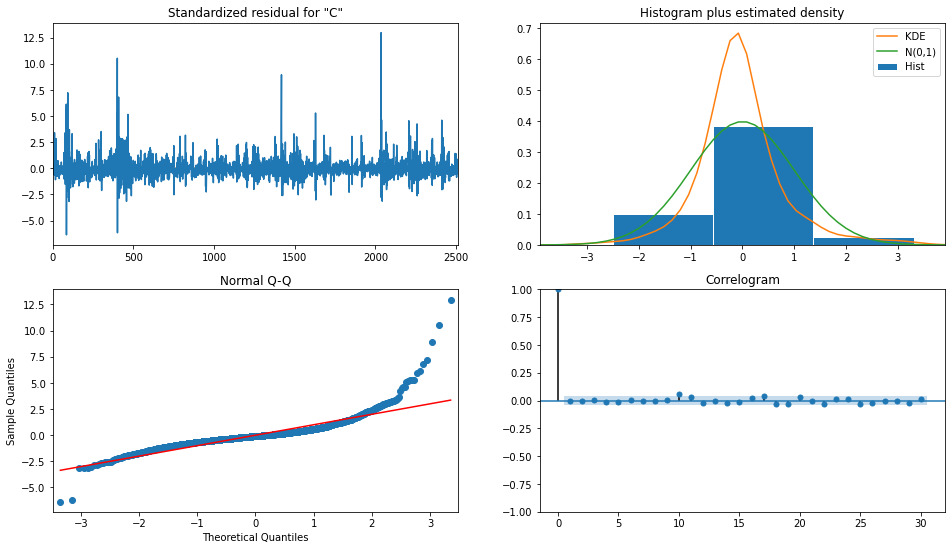

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = result.plot_diagnostics(fig=fig, lags=30)

Clearly, if we wanted to pursue this further, there are many things we could look at:

1. Out of sample forcasting
2. Setting the first lags to zero (since their p-values are large).
3. Can we use MCMC to consider a non-Guassian White Noise term?
4. Other ideas?


